In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)


In [11]:
# Helper function to calculate normalized resistance (R/R0)
def calculate_normalized_resistance(group):
    """Calculate R/R0 where R0 is the first resistance value in the cycle"""
    R0 = group['gas_resistance_ohm'].iloc[0]
    result = group.copy()
    result['R_R0'] = result['gas_resistance_ohm'] / R0
    return result


Found 3 Natural Air files and 1 Coffee file

Processing bme690_Coffee___Dunkin___Hazelnut___Yes___No_160804.csv...
  ✓ ☕ Coffee Exposure (Coffee-160804): 50 cycles, 500 data points
    Profile: HP-502-5sDwell
    R/R0 range: 0.355 - 3.753

Processing bme690_Natural_Air___Inside_144854.csv...
  ✓ Natural Air-144854: 11 cycles, 107 data points
    Profile: HP-502-5sDwell
    R/R0 range: 0.396 - 14.183

Processing bme690_Natural_Air___Inside_145956.csv...
  ✓ Natural Air-145956: 50 cycles, 500 data points
    Profile: HP-502-5sDwell
    R/R0 range: 0.386 - 16.557

Processing bme690_Natural_Air___Inside_165947.csv...
  ✓ Natural Air-165947: 100 cycles, 1000 data points
    Profile: HP-502-5sDwell
    R/R0 range: 0.480 - 11.310


C:\Users\faizan.z\AppData\Local\Temp\ipykernel_24220\477866574.py:94: UserWarning: Glyph 9749 (\N{HOT BEVERAGE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\faizan.z\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9749 (\N{HOT BEVERAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


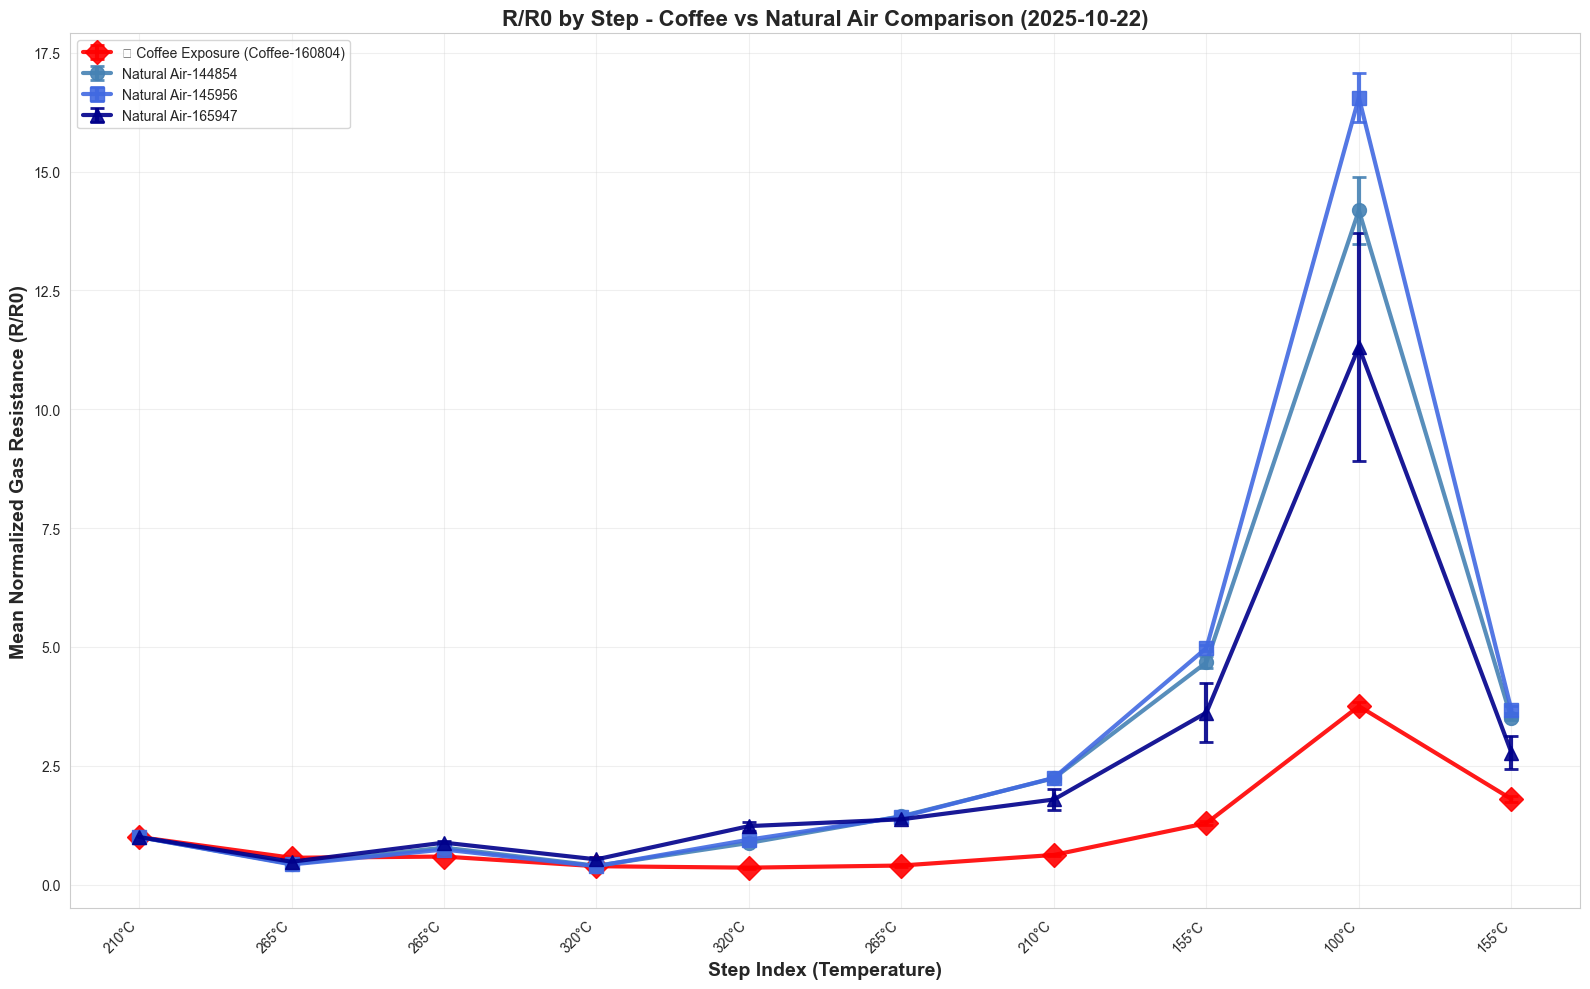

In [18]:
# Load and process all Natural Air files from 2025-10-22 + Coffee file
# ========================================================================

# Natural Air files
files_dir = '../e_sniffer_bme690_poc/logs/Natural_Air/Inside/2025-10-22/'
natural_air_files = sorted(glob.glob(os.path.join(files_dir, '*.csv')))

# Coffee file
coffee_file = '../e_sniffer_bme690_poc/logs/Coffee/Dunkin/2025-10-22/bme690_Coffee___Dunkin___Hazelnut___Yes___No_160804.csv'

# Combine all files with labels
files_to_plot = [
    (coffee_file, 'red', 'D', 'Coffee'),  # Coffee file in red with diamond marker
]

# Add Natural Air files with blue tones
colors = ['steelblue', 'royalblue', 'darkblue', 'navy']
markers = ['o', 's', '^', 'v']
for file_path, color, marker in zip(natural_air_files, colors, markers):
    files_to_plot.append((file_path, color, marker, 'Natural Air'))

print(f"Found {len(natural_air_files)} Natural Air files and 1 Coffee file")

plt.figure(figsize=(16, 10))

# Process and plot each file
for file_path, color, marker, label_type in files_to_plot:
    # Extract filename for label
    filename = os.path.basename(file_path)
    
    if 'Coffee' in filename:
        timestamp = 'Coffee-160804'
        display_label = f'☕ Coffee Exposure ({timestamp})'
    else:
        timestamp = filename.replace('bme690_Natural_Air___Inside_', '').replace('.csv', '')
        display_label = f'Natural Air-{timestamp}'
    
    print(f"\nProcessing {filename}...")
    
    # Load data
    df_temp = pd.read_csv(file_path)
    
    # Skip files with too few rows (corrupted/incomplete files)
    if len(df_temp) < 10:
        print(f"  ⚠ Skipping {filename}: Only {len(df_temp)} rows")
        continue
    
    # Extract profile name if available
    profile_name = df_temp['profile_name'].iloc[0] if 'profile_name' in df_temp.columns else 'Unknown'
    
    # Count cycles before transformation
    num_cycles = df_temp['cycle_index'].nunique()
    
    # Calculate R/R0
    df_temp = df_temp.groupby('cycle_index', group_keys=False).apply(
        calculate_normalized_resistance, include_groups=False
    ).reset_index(drop=True)
    
    # Calculate mean R/R0 and std by step
    step_data = df_temp.groupby('step_index').agg({
        'R_R0': ['mean', 'std'],
        'commanded_heater_temp_C': 'mean'
    }).reset_index()
    step_data.columns = ['step_index', 'R_R0_mean', 'R_R0_std', 'commanded_heater_temp_C']
    
    # Plot with error bars
    plt.errorbar(step_data['step_index'],
                 step_data['R_R0_mean'],
                 yerr=step_data['R_R0_std'],
                 marker=marker,
                 linewidth=3,
                 markersize=12 if 'Coffee' in filename else 10,
                 color=color,
                 label=f'{display_label}',
                 capsize=5,
                 capthick=2,
                 alpha=0.9)
    print(f"  ✓ {display_label}: {num_cycles} cycles, {len(df_temp)} data points")
    print(f"    Profile: {profile_name}")
    print(f"    R/R0 range: {step_data['R_R0_mean'].min():.3f} - {step_data['R_R0_mean'].max():.3f}")

# Set x-axis ticks to show temperature at each step
plt.xticks(step_data['step_index'], 
           [f"{int(temp)}°C" for temp in step_data['commanded_heater_temp_C']],
           rotation=45,
           ha='right')

plt.xlabel('Step Index (Temperature)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Normalized Gas Resistance (R/R0)', fontsize=14, fontweight='bold')
plt.title('R/R0 by Step - Coffee vs Natural Air Comparison (2025-10-22)',
          fontsize=16, fontweight='bold')
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Loading bme690_Natural_Air___Inside_165947.csv...


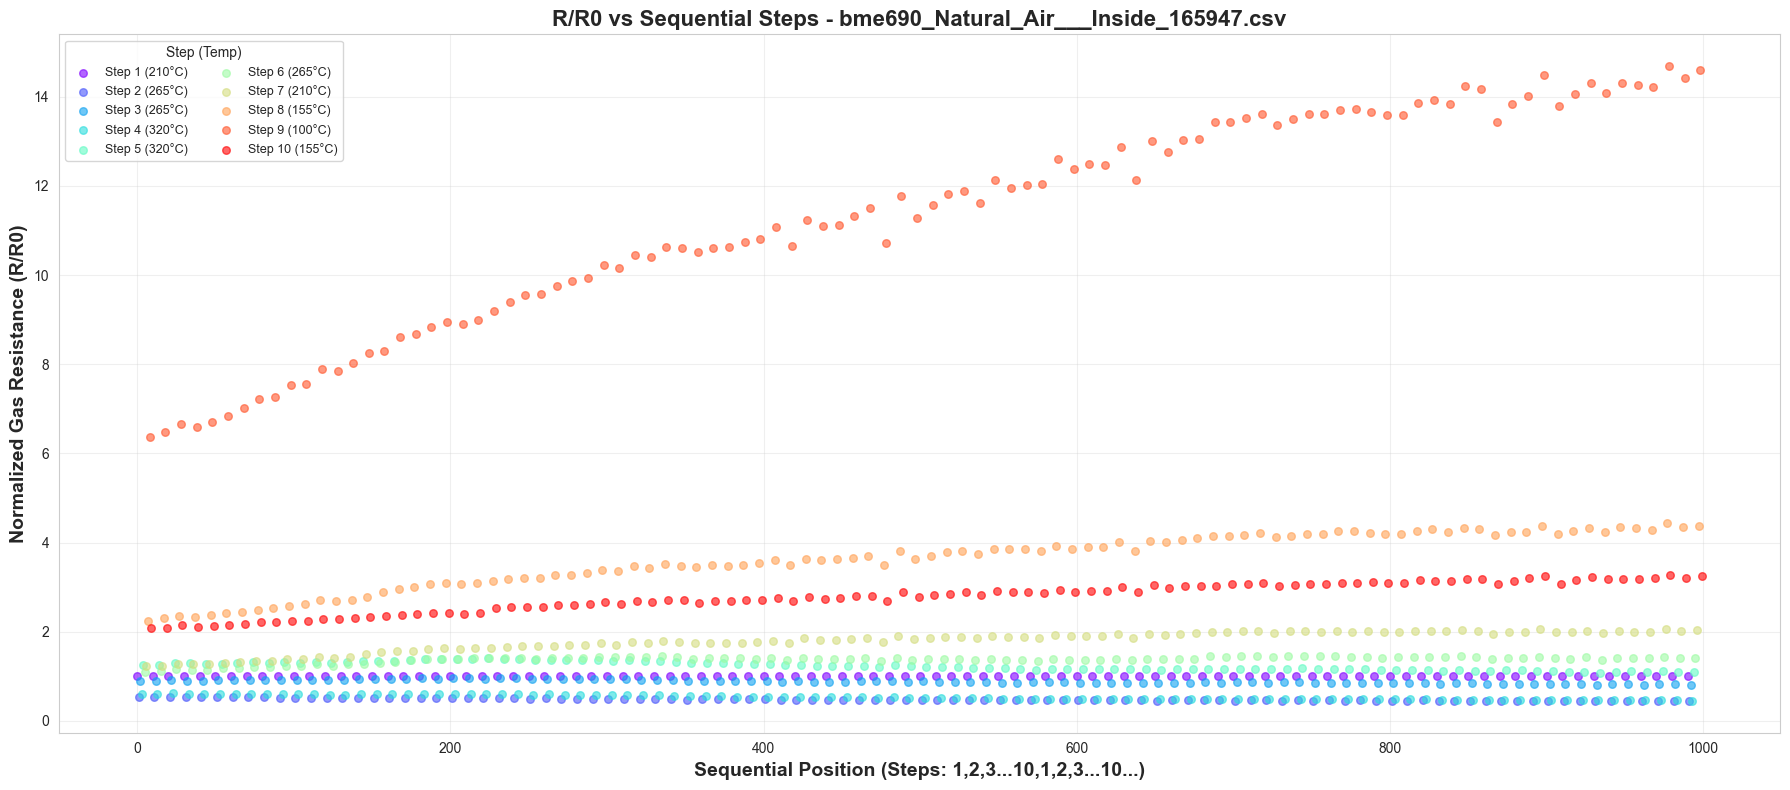


Total data points: 1000
Number of cycles: 99
Steps per cycle: 10
Step pattern repeats every 10 measurements


In [14]:
# Plot R/R0 vs sequential steps for single file (all cycles shown)
# ====================================================================

file_path = '../e_sniffer_bme690_poc/logs/Natural_Air/Inside/2025-10-22/bme690_Natural_Air___Inside_165947.csv'

print(f"Loading {os.path.basename(file_path)}...")

# Load data
df = pd.read_csv(file_path)

# Calculate R/R0 for each cycle
df = df.groupby('cycle_index', group_keys=False).apply(
    calculate_normalized_resistance, include_groups=False
).reset_index(drop=True)

# Create a sequential position index for plotting
df['position'] = range(len(df))

# Get unique step indices for coloring
unique_steps = sorted(df['step_index'].unique())
step_colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_steps)))
step_color_map = dict(zip(unique_steps, step_colors))

# Create the plot
plt.figure(figsize=(18, 8))

# Plot each step with a different color
for step in unique_steps:
    mask = df['step_index'] == step
    temp = df[mask]['commanded_heater_temp_C'].iloc[0]
    plt.scatter(df[mask]['position'], 
                df[mask]['R_R0'],
                c=[step_color_map[step]],
                label=f'Step {step} ({int(temp)}°C)',
                alpha=0.6,
                s=30)

plt.xlabel('Sequential Position (Steps: 1,2,3...10,1,2,3...10...)', fontsize=14, fontweight='bold')
plt.ylabel('Normalized Gas Resistance (R/R0)', fontsize=14, fontweight='bold')
plt.title(f'R/R0 vs Sequential Steps - {os.path.basename(file_path)}',
          fontsize=16, fontweight='bold')
plt.legend(fontsize=9, loc='best', title='Step (Temp)', ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal data points: {len(df)}")
print(f"Number of cycles: {df['position'].max() // len(unique_steps)}")
print(f"Steps per cycle: {len(unique_steps)}")
print(f"Step pattern repeats every {len(unique_steps)} measurements")


Loading bme690_Natural_Air___Inside_145956.csv...


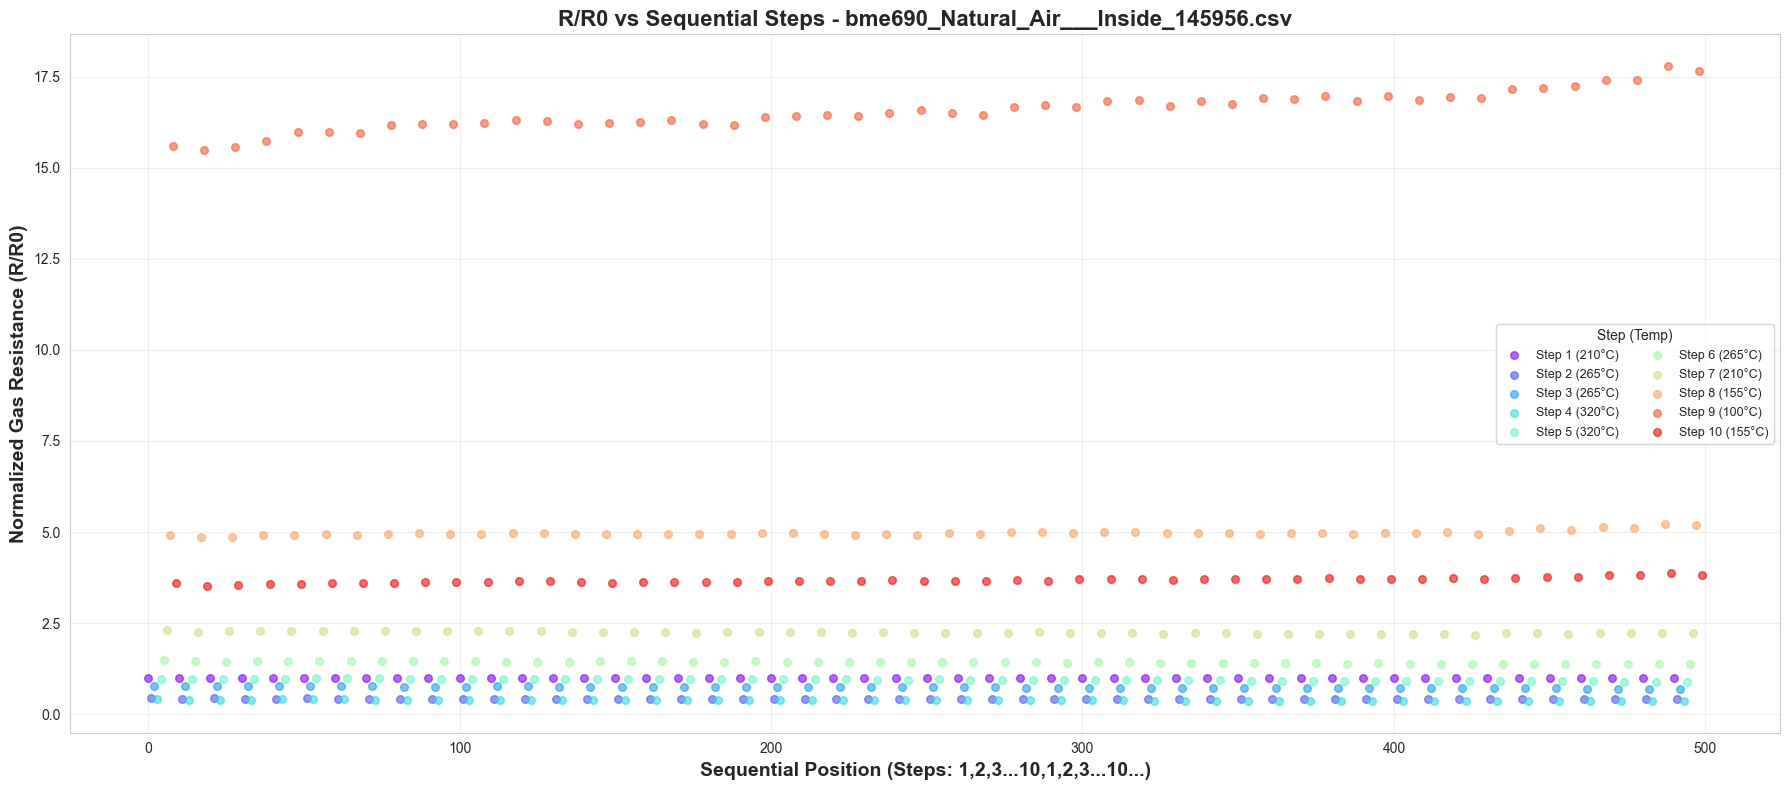


Total data points: 500
Number of cycles: 49
Steps per cycle: 10
Step pattern repeats every 10 measurements


In [15]:
# Plot R/R0 vs sequential steps for bme690_Natural_Air___Inside_145956.csv
# =========================================================================

file_path = '../e_sniffer_bme690_poc/logs/Natural_Air/Inside/2025-10-22/bme690_Natural_Air___Inside_145956.csv'

print(f"Loading {os.path.basename(file_path)}...")

# Load data
df = pd.read_csv(file_path)

# Calculate R/R0 for each cycle
df = df.groupby('cycle_index', group_keys=False).apply(
    calculate_normalized_resistance, include_groups=False
).reset_index(drop=True)

# Create a sequential position index for plotting
df['position'] = range(len(df))

# Get unique step indices for coloring
unique_steps = sorted(df['step_index'].unique())
step_colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_steps)))
step_color_map = dict(zip(unique_steps, step_colors))

# Create the plot
plt.figure(figsize=(18, 8))

# Plot each step with a different color
for step in unique_steps:
    mask = df['step_index'] == step
    temp = df[mask]['commanded_heater_temp_C'].iloc[0]
    plt.scatter(df[mask]['position'], 
                df[mask]['R_R0'],
                c=[step_color_map[step]],
                label=f'Step {step} ({int(temp)}°C)',
                alpha=0.6,
                s=30)

plt.xlabel('Sequential Position (Steps: 1,2,3...10,1,2,3...10...)', fontsize=14, fontweight='bold')
plt.ylabel('Normalized Gas Resistance (R/R0)', fontsize=14, fontweight='bold')
plt.title(f'R/R0 vs Sequential Steps - {os.path.basename(file_path)}',
          fontsize=16, fontweight='bold')
plt.legend(fontsize=9, loc='best', title='Step (Temp)', ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal data points: {len(df)}")
print(f"Number of cycles: {df['position'].max() // len(unique_steps)}")
print(f"Steps per cycle: {len(unique_steps)}")
print(f"Step pattern repeats every {len(unique_steps)} measurements")


Loading bme690_Natural_Air___Inside_144854.csv...
Valid data points after removing NaN: 96


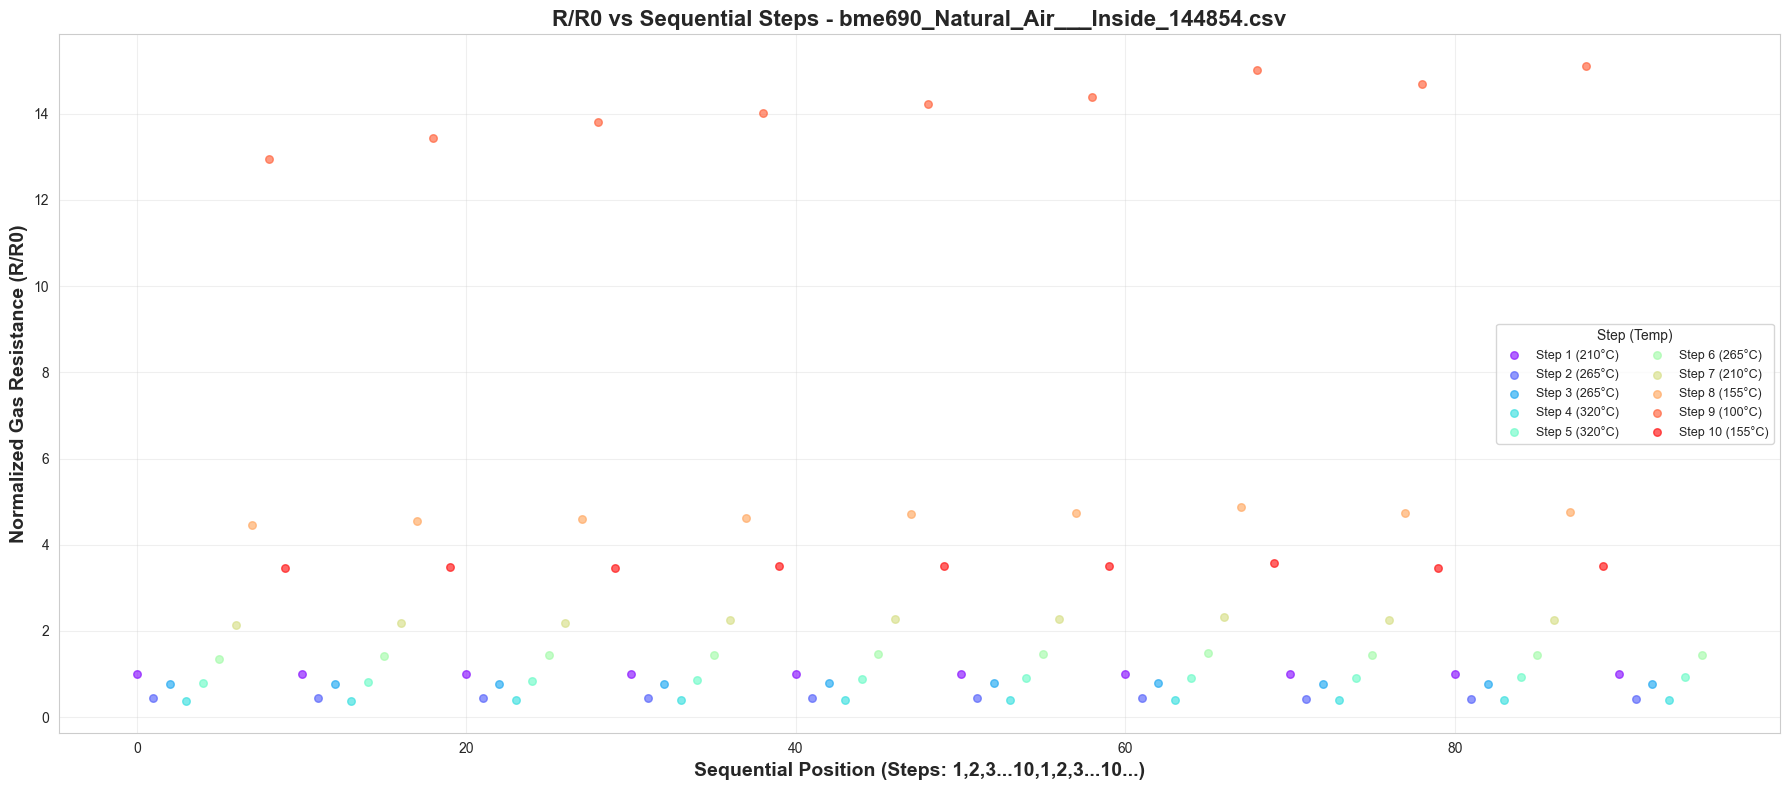


Total data points: 96
Number of cycles: 9
Steps per cycle: 10
Step pattern repeats every 10 measurements


In [16]:
# Plot R/R0 vs sequential steps for bme690_Natural_Air___Inside_144854.csv
# =========================================================================

file_path = '../e_sniffer_bme690_poc/logs/Natural_Air/Inside/2025-10-22/bme690_Natural_Air___Inside_144854.csv'

print(f"Loading {os.path.basename(file_path)}...")

# Load data
df = pd.read_csv(file_path)

# Remove rows with NaN gas_resistance values (corrupted data at end)
df = df.dropna(subset=['gas_resistance_ohm'])

print(f"Valid data points after removing NaN: {len(df)}")

# Calculate R/R0 for each cycle
df = df.groupby('cycle_index', group_keys=False).apply(
    calculate_normalized_resistance, include_groups=False
).reset_index(drop=True)

# Create a sequential position index for plotting
df['position'] = range(len(df))

# Get unique step indices for coloring
unique_steps = sorted(df['step_index'].unique())
step_colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_steps)))
step_color_map = dict(zip(unique_steps, step_colors))

# Create the plot
plt.figure(figsize=(18, 8))

# Plot each step with a different color
for step in unique_steps:
    mask = df['step_index'] == step
    temp = df[mask]['commanded_heater_temp_C'].iloc[0]
    plt.scatter(df[mask]['position'], 
                df[mask]['R_R0'],
                c=[step_color_map[step]],
                label=f'Step {step} ({int(temp)}°C)',
                alpha=0.6,
                s=30)

plt.xlabel('Sequential Position (Steps: 1,2,3...10,1,2,3...10...)', fontsize=14, fontweight='bold')
plt.ylabel('Normalized Gas Resistance (R/R0)', fontsize=14, fontweight='bold')
plt.title(f'R/R0 vs Sequential Steps - {os.path.basename(file_path)}',
          fontsize=16, fontweight='bold')
plt.legend(fontsize=9, loc='best', title='Step (Temp)', ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal data points: {len(df)}")
print(f"Number of cycles: {df['position'].max() // len(unique_steps)}")
print(f"Steps per cycle: {len(unique_steps)}")
print(f"Step pattern repeats every {len(unique_steps)} measurements")


Loading bme690_Coffee___Dunkin___Hazelnut___Yes___No_160804.csv...
Valid data points: 500


C:\Users\faizan.z\AppData\Local\Temp\ipykernel_24220\4076253898.py:55: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\faizan.z\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


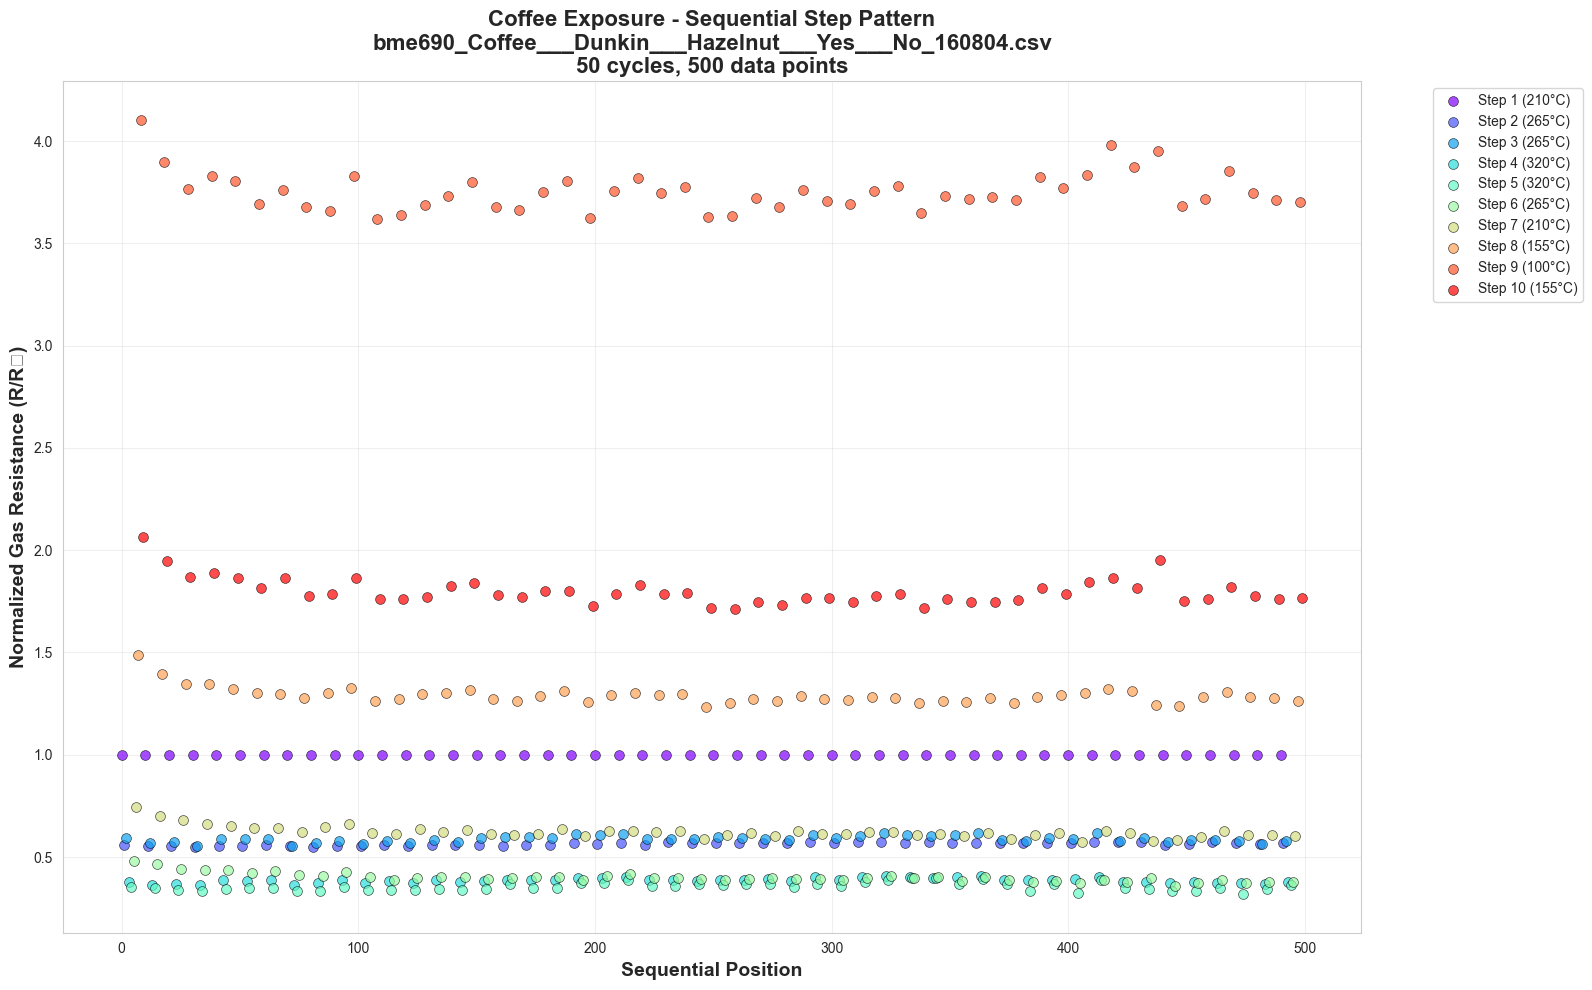


✓ Coffee data: 50 cycles, 500 data points


In [17]:
# Plot R/R0 vs sequential steps for Coffee data
# =================================================

file_path = '../e_sniffer_bme690_poc/logs/Coffee/Dunkin/2025-10-22/bme690_Coffee___Dunkin___Hazelnut___Yes___No_160804.csv'

print(f"Loading {os.path.basename(file_path)}...")

# Load data
df = pd.read_csv(file_path)

# Remove rows with NaN gas_resistance values if any
df = df.dropna(subset=['gas_resistance_ohm'])

print(f"Valid data points: {len(df)}")

# Calculate number of cycles before transformation
num_cycles = df['cycle_index'].nunique()

# Calculate R/R0 for each cycle
df = df.groupby('cycle_index', group_keys=False).apply(
    calculate_normalized_resistance, include_groups=False
).reset_index(drop=True)

# Create a sequential position index for plotting
df['position'] = range(len(df))

# Get unique step indices for coloring
unique_steps = sorted(df['step_index'].unique())
step_colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_steps)))
step_color_map = dict(zip(unique_steps, step_colors))

# Create the plot
plt.figure(figsize=(16, 10))

# Plot each step with its own color
for step_idx in unique_steps:
    step_mask = df['step_index'] == step_idx
    step_temp = df[step_mask]['commanded_heater_temp_C'].iloc[0]
    
    plt.scatter(df[step_mask]['position'], 
               df[step_mask]['R_R0'],
               c=[step_color_map[step_idx]], 
               label=f'Step {step_idx} ({step_temp:.0f}°C)',
               alpha=0.7,
               s=50,
               edgecolors='black',
               linewidths=0.5)

plt.xlabel('Sequential Position', fontsize=14, fontweight='bold')
plt.ylabel('Normalized Gas Resistance (R/R₀)', fontsize=14, fontweight='bold')
plt.title(f'Coffee Exposure - Sequential Step Pattern\n{os.path.basename(file_path)}\n{num_cycles} cycles, {len(df)} data points', 
         fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Coffee data: {num_cycles} cycles, {len(df)} data points")


Loading bme690_Natural_Air___Inside_012456.csv...
Valid data points: 6836


C:\Users\faizan.z\AppData\Local\Temp\ipykernel_24220\1032570482.py:55: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\faizan.z\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


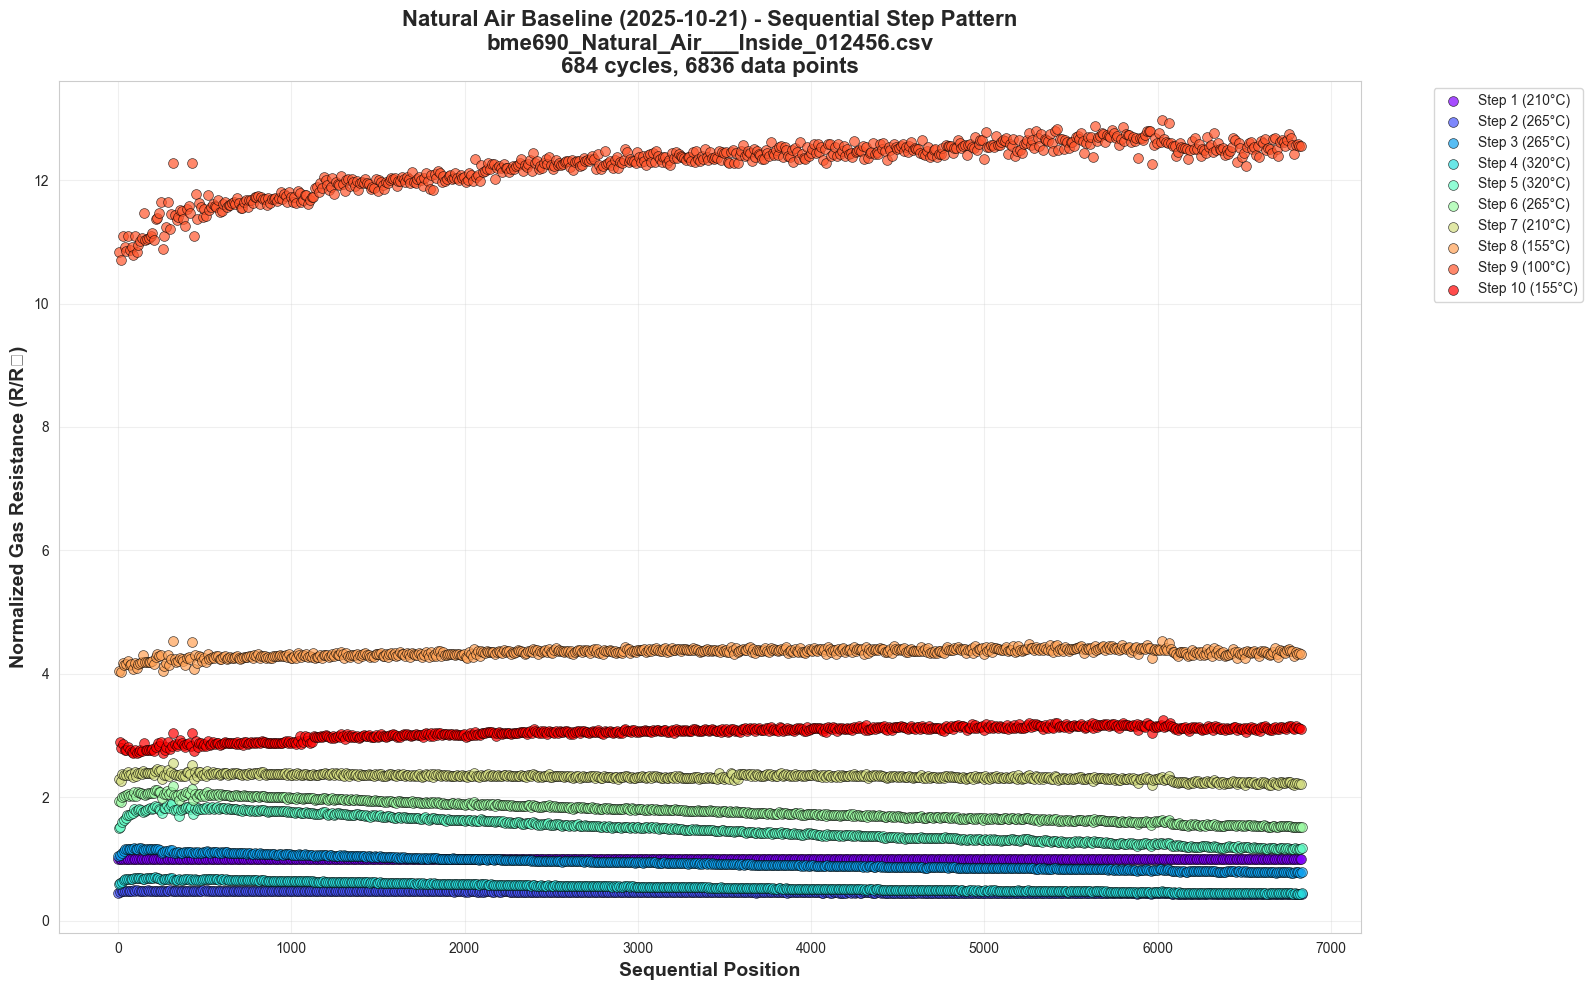


✓ 2025-10-21 baseline: 684 cycles, 6836 data points


In [19]:
# Plot R/R0 vs sequential steps for 2025-10-21 baseline data
# =============================================================

file_path = '../e_sniffer_bme690_poc/logs/Natural_Air/Inside/2025-10-21/bme690_Natural_Air___Inside_012456.csv'

print(f"Loading {os.path.basename(file_path)}...")

# Load data
df = pd.read_csv(file_path)

# Remove rows with NaN gas_resistance values if any
df = df.dropna(subset=['gas_resistance_ohm'])

print(f"Valid data points: {len(df)}")

# Calculate number of cycles before transformation
num_cycles = df['cycle_index'].nunique()

# Calculate R/R0 for each cycle
df = df.groupby('cycle_index', group_keys=False).apply(
    calculate_normalized_resistance, include_groups=False
).reset_index(drop=True)

# Create a sequential position index for plotting
df['position'] = range(len(df))

# Get unique step indices for coloring
unique_steps = sorted(df['step_index'].unique())
step_colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_steps)))
step_color_map = dict(zip(unique_steps, step_colors))

# Create the plot
plt.figure(figsize=(16, 10))

# Plot each step with its own color
for step_idx in unique_steps:
    step_mask = df['step_index'] == step_idx
    step_temp = df[step_mask]['commanded_heater_temp_C'].iloc[0]
    
    plt.scatter(df[step_mask]['position'], 
               df[step_mask]['R_R0'],
               c=[step_color_map[step_idx]], 
               label=f'Step {step_idx} ({step_temp:.0f}°C)',
               alpha=0.7,
               s=50,
               edgecolors='black',
               linewidths=0.5)

plt.xlabel('Sequential Position', fontsize=14, fontweight='bold')
plt.ylabel('Normalized Gas Resistance (R/R₀)', fontsize=14, fontweight='bold')
plt.title(f'Natural Air Baseline (2025-10-21) - Sequential Step Pattern\n{os.path.basename(file_path)}\n{num_cycles} cycles, {len(df)} data points', 
         fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ 2025-10-21 baseline: {num_cycles} cycles, {len(df)} data points")
